In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
!python --version

Python 3.7.0


In [3]:
from models.GeoNet.model import DocGeoNet
from models.GeoNet.unet import U2NETP
import cv2

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import skimage.io as io
import numpy as np
import cv2
import os
from PIL import Image
import argparse
import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/2017310887/miniconda3/envs/fl2/lib/python3.7/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [178]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.msk = U2NETP(3, 1)
        self.DocTr = DocGeoNet()

    def forward(self, x):
        msk, _1,_2,_3,_4,_5,_6 = self.msk(x)
        msk = (msk > 0.9).float()
        x = msk * x
        #print(x)

        _, _, bm = self.DocTr(x)
        bm = (2 * (bm / 255.) - 1) * 0.99
        #return bm
        return x, bm


def reload_seg_model(model, path=""):
    if not bool(path):
        return model
    else:
        model_dict = model.state_dict()
        pretrained_dict = torch.load(path, map_location='cuda:0')
        print(len(pretrained_dict.keys()))
        pretrained_dict = {k[6:]: v for k, v in pretrained_dict.items() if k[6:] in model_dict}
        print(len(pretrained_dict.keys()))
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)

        return model


def reload_rec_model(model, path=""):
    if not bool(path):
        return model
    else:
        model_dict = model.state_dict()
        pretrained_dict = torch.load(path, map_location='cuda:0')
        print(len(pretrained_dict.keys()))
        pretrained_dict = {k[7:]: v for k, v in pretrained_dict.items() if k[7:] in model_dict}
        print(len(pretrained_dict.keys()))
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)

        return model




def get_parameter_number(net):
    total_num = sum(p.numel() for p in net.parameters())
    trainable_num = sum(p.numel() for p in net.parameters() if p.requires_grad)
    return {'Total': total_num, 'Trainable': trainable_num}




In [179]:
img_path = "./receipt_images/000.jpg"
geonet_path = "./weights/GeoNet/DocGeoNet.pth"
unet_path = "./weights/GeoNet/preprocess.pth"


In [180]:
net = Net().to(device)

In [181]:
reload_rec_model(net.DocTr, geonet_path)
reload_seg_model(net.msk, unet_path)
net.eval()

489
489
798
798


Net(
  (msk): U2NETP(
    (stage1): RSU7(
      (rebnconvin): REBNCONV(
        (conv_s1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn_s1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu_s1): ReLU(inplace=True)
      )
      (rebnconv1): REBNCONV(
        (conv_s1): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn_s1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu_s1): ReLU(inplace=True)
      )
      (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
      (rebnconv2): REBNCONV(
        (conv_s1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn_s1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu_s1): ReLU(inplace=True)
      )
      (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
      (re

In [182]:
im_ori = np.array(Image.open(img_path))[:, :, :3] / 255.  # read image 0-255 to 0-1

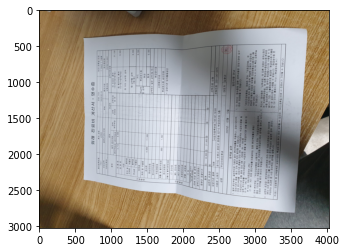

In [183]:
plt.imshow(im_ori)

In [253]:
h, w, _ = im_ori.shape
im = cv2.resize(im_ori, (256, 256))
im = im.transpose(2, 0, 1)
im = torch.from_numpy(im).float().unsqueeze(0)

In [254]:
# bm = net(im.to(device))
# bm = bm.detach().cpu()

x, bm = net(im.to(device))
x, bm = x.detach().cpu(), bm.detach().cpu()

In [255]:
# bm0 = F.interpolate(bm[0,0].unsqueeze(0).unsqueeze(0), size=[h, w], mode='nearest')
# bm1 = F.interpolate(bm[0,1].unsqueeze(0).unsqueeze(0), size=[h, w], mode='nearest')

# bm0 = bm0[0][0].numpy()
# bm1 = bm1[0][0].numpy()

# print(bm0.shape)

In [256]:
# # save rectified image
bm0 = cv2.resize(bm[0, 0].numpy(), (w, h))  # x flow
bm1 = cv2.resize(bm[0, 1].numpy(), (w, h))  # y flow
print(bm0.shape)

(3024, 4032)


In [257]:
bm0 = cv2.blur(bm0, (3, 3))
bm1 = cv2.blur(bm1, (3, 3))
lbl = torch.from_numpy(np.stack([bm0, bm1], axis=2)).unsqueeze(0)  # h * w * 2


In [258]:
out = F.grid_sample(torch.from_numpy(im_ori).permute(2, 0, 1).unsqueeze(0).float(), lbl, align_corners=True)
print(out.shape)

torch.Size([1, 3, 3024, 4032])


In [259]:
x = (x[0] * 255).permute(1, 2, 0).numpy().astype(np.uint8)
out = (out[0] * 255).permute(1, 2, 0).numpy().astype(np.uint8)
#out = (out[0] * 255).permute(1, 2, 0).numpy()[:,:,::-1].astype(np.uint8) # changes to BRG

print(out.shape)

(3024, 4032, 3)


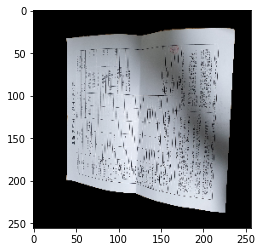

In [260]:
plt.imshow(x)

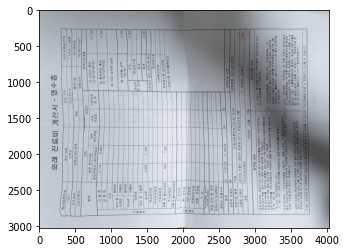

In [261]:
plt.imshow(out)

In [194]:
out_under = cv2.resize(out, (2048, 1536))  # x flow


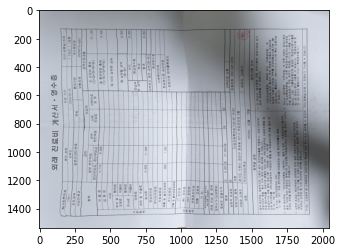

In [195]:
plt.imshow(out_under)

In [196]:
cv2.imwrite('_rec.png', out_under[:,:,::-1])


True